In [1]:
import pandas
import matplotlib
import collections
import seaborn
import re
import lifelines
import statsmodels.api as sm 

%matplotlib inline

seaborn.set_style('whitegrid')
seaborn.set_palette('colorblind')

In [2]:
ecosystems = ['npm', 'cran', 'rubygems']

COLORS = collections.OrderedDict()
for i, ecos in enumerate(ecosystems):
    COLORS[ecos] = seaborn.color_palette()[i]

DATE_RANGE = pandas.date_range('2011-01-01', '2016-09-01', freq='6M')
    
FIG_SIZE = (6, 3)
SAVE_FIG = True

SHOW_TITLE = not SAVE_FIG

REGEX_LOOSE_VERSION = re.compile(r'http|\^|~|>|<|\*|\.x')
REGEX_LOWER_BOUND_VERSION = re.compile(r'\^|~|>|\.\*|\.x')
REGEX_UPPER_BOUND_VERSION = re.compile(r'\^|~|<|\.\*|\.x')

In [3]:
def savefig(fig, name):
    # (Un)comment next line to (enable) disable export
    if SAVE_FIG:
        return fig.savefig('../figures/{}.pdf'.format(name), bbox_inches='tight')
    else:
        return
    
def snapshot(date, packages, dependencies):
    """
    Return a 2-uple (packages, dependencies) of dataframes that only contain
    information that were available and valid at given date.
    """
    date = pandas.to_datetime(date)
    pkg = packages[packages['time'] <= date].sort_values('time').groupby(level='package', sort=False).tail(1)
    deps = dependencies.merge(pkg, how='inner', left_on=['package', 'version'], right_index=True)
    deps = deps.drop('time', axis=1)
    return (pkg, deps)

In [4]:
df_pkg = collections.OrderedDict()
df_deps = collections.OrderedDict()
df_delay = collections.OrderedDict()

for ecosystem in ecosystems: 
    pkg = pandas.read_csv('../data/{ecosystem}/packages.csv.gz'.format(ecosystem=ecosystem), 
                          usecols=['package', 'version', 'time', 'size'],
                          index_col=['package', 'version'])
    pkg['time'] = pandas.to_datetime(pkg['time'], utc=True, infer_datetime_format=True)
    deps = pandas.read_csv('../data/{ecosystem}/dependencies.csv.gz'.format(ecosystem=ecosystem),
                           usecols=['package', 'version', 'dependency', 'constraint'])
    
    # Constraints
    deps['constraint_defined'] = deps['constraint'] != '*'
    deps['constraint_strict'] = ~ deps['constraint'].str.contains(REGEX_LOOSE_VERSION)
    deps['constraint_lower'] = deps['constraint'].str.contains(REGEX_LOWER_BOUND_VERSION)
    deps['constraint_upper'] = deps['constraint'].str.contains(REGEX_UPPER_BOUND_VERSION)
    deps['constraint_unknown'] = ~(deps['constraint_strict'] | deps['constraint_upper'] | deps['constraint_lower'])
    deps['constraint'] = deps['constraint'].where(~deps['constraint_strict'], deps['constraint'].str.replace('=', '').str.strip(), axis=0)    
    
    # Time of next update
    pkg = (pkg
        .reset_index()
        .sort_values(['package', 'time'])
        .set_index(['package', 'version'])
        .assign(next_time=lambda d: d['time'].shift(-1))
    )
    last_updates = (pkg
        .groupby(level='package', sort=False)
        .tail(1)
        .index
    )
    pkg.loc[last_updates, 'next_time'] = pandas.NaT
           
    # Delay since a dependency (constraint) is updated
    delay = (pkg
        .merge(deps, left_index=True, right_on=['package', 'version'], how='inner')
        .sort_values('time')
        .drop_duplicates(['package', 'dependency', 'constraint'], keep='first')
        .sort_values(['package', 'dependency', 'time'])
        .reset_index(drop=True)
        .assign(next_time=lambda d: d['time'].shift(-1))
    )
    last_updates = (delay
        .groupby(['package', 'dependency'], sort=False)
        .tail(1)
        .index
    )
    delay.loc[last_updates, 'next_time'] = pandas.NaT
       
                    
    df_pkg[ecosystem] = pkg
    df_deps[ecosystem] = deps
    df_delay[ecosystem] = delay

# Overview

In [5]:
df = pandas.DataFrame(index=ecosystems)

for ecos in ecosystems:
    latest_date = df_pkg[ecos]['time'].max()
    oldest_date = df_pkg[ecos].query('time > 1970')['time'].min()
    snapshot_pkg, snapshot_deps = snapshot(latest_date, df_pkg[ecos], df_deps[ecos])
    
    df.loc[ecos, 'packages'] = len(df_pkg[ecos].groupby(level=0))
    df.loc[ecos, 'versions'] = len(df_pkg[ecos])
    df.loc[ecos, 'dependencies'] = len(df_deps[ecos])
    
    df.loc[ecos, 'snapshot'] = latest_date
    df.loc[ecos, 'deps in snapshot'] = len(snapshot_deps)
    
    df.loc[ecos, 'latest_package'] = latest_date
    df.loc[ecos, 'oldest_package'] = oldest_date
    
df['versions_mean'] = df['packages'] / df['versions']
df['dependencies_mean'] = df['dependencies'] / df['versions']

df

,packages,versions,dependencies,snapshot,deps in snapshot,latest_package,oldest_package,versions_mean,dependencies_mean
npm,317159.0,1927750.0,7644295.0,2016-06-28 14:35:28.717,728440.0,2016-06-28 14:35:28.717,2010-11-09 23:36:08,0.164523,3.965397
cran,9568.0,57530.0,128113.0,2016-04-26 20:52:26.000,22191.0,2016-04-26 20:52:26.000,1997-10-08 19:56:17,0.166313,2.226890
rubygems,122791.0,685591.0,1674823.0,2016-09-07 14:02:43.409,183127.0,2016-09-07 14:02:43.409,2009-07-25 17:46:22,0.179102,2.442889


## Evolution of the number of packages/releases

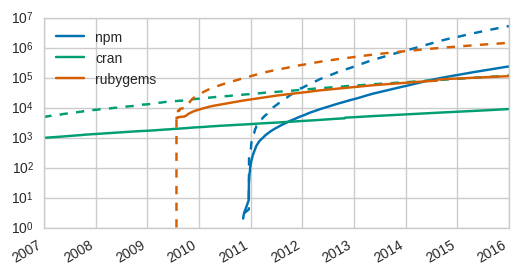

In [41]:
fig, ax = matplotlib.pyplot.subplots()

for ecos in ecosystems:
    df = (df_pkg[ecos]
        .query('time > "1970-01-01"')
        .groupby(level='package')
        [['time']]
        .min()
        .assign(time=lambda d: d.time.dt.date)
        .assign(**{ecos:1})
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
    ) 
    df.plot(ax=ax, color=COLORS[ecos], logy=True)

    df = (df_pkg[ecos]
        [['time']]
        .merge(
            (df_deps[ecos]
                .assign(n=1)
                .groupby(['package', 'version'])
                 [['n']]
                 .count()
            )
            , how='right', left_index=True, right_index=True)
        .set_index('time')
        .fillna(0)
        .sort_index()
        .cumsum()
    )
    df.plot(ax=ax, color=COLORS[ecos], legend=None, style='--', logy=True)

if SHOW_TITLE:
    ax.set_title('Number of available packages and dependencies')
    
ax.set_xlabel('')    
#ax.set_ylabel('# packages')
ax.set_ylabel('')
ax.set_xlim(left=pandas.to_datetime('2007-01-01'), right=pandas.to_datetime('2016-01-01'))

fig.set_size_inches(FIG_SIZE)

savefig(fig, 'packages_evolution')

In [49]:
data = {'packages': {}, 'dependencies': {}}

for ecos in ecosystems:
    df = (df_pkg[ecos]
        .query('time > "1970-01-01"')
        .groupby(level='package')
        [['time']]
        .min()
        .assign(**{ecos:1})  
        .assign(time=lambda d: d.time.dt.date)
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
        .reset_index()
        .assign(days=lambda d: 1 + (d['time'] - d['time'].min()).dt.days)
    ) 
    
    data['packages'][ecos] = df
    
    results = sm.OLS(df['days'], df[ecos]).fit()
    print(ecos, 'pkg lin-lin', results.rsquared)
    
    results = sm.OLS(df['days'], pandas.np.log10(df[ecos])).fit()
    print(ecos, 'pkg lin-log', results.rsquared)
    
    results = sm.OLS(pandas.np.log10(df['days']), df[ecos]).fit()
    print(ecos, 'pkg log-lin', results.rsquared)
    
    results = sm.OLS(pandas.np.log10(df['days']), pandas.np.log10(df[ecos])).fit()
    print(ecos, 'pkg log-log', results.rsquared)
    
    df = (df_pkg[ecos]
        .query('time > "1970-01-01"')
        [['time']]
        .merge(
            (df_deps[ecos]
                .assign(**{ecos:1})
                .groupby(['package', 'version'])
                 [[ecos]]
                 .count()
            )
            , how='right', left_index=True, right_index=True)
        .assign(time=lambda d: d.time.dt.date)
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
        .reset_index()
        .assign(days=lambda d: 1 + (d['time'] - d['time'].min()).dt.days)
    )
    
    data['dependencies'][ecos] = df
    
    results = sm.OLS(df['days'], df[ecos]).fit()
    print(ecos, 'deps lin-lin', results.rsquared)
    
    results = sm.OLS(df['days'], pandas.np.log10(df[ecos])).fit()
    print(ecos, 'deps lin-log', results.rsquared)
    
    results = sm.OLS(pandas.np.log10(df['days']), df[ecos]).fit()
    print(ecos, 'deps log-lin', results.rsquared)
    
    results = sm.OLS(pandas.np.log10(df['days']), pandas.np.log10(df[ecos])).fit()
    print(ecos, 'deps log-log', results.rsquared)
    print()

print('powerlaw: http://www.xuru.org/rt/powr.asp')

npm pkg lin-lin 0.840439648376
npm pkg lin-log 0.887774943269
npm pkg log-lin 0.537220132352
npm pkg log-log 0.996797112952
npm deps lin-lin 0.766488542672
npm deps lin-log 0.887209811877
npm deps log-lin 0.461544862432
npm deps log-log 0.996895608111

cran pkg lin-lin 0.871260873728
cran pkg lin-log 0.974430839555
cran pkg log-lin 0.688445397594
cran pkg log-log 0.990097049808
cran deps lin-lin 0.787089208421
cran deps lin-log 0.973418797786
cran deps log-lin 0.558811969732
cran deps log-log 0.982863564851

rubygems pkg lin-lin 0.992424138101
rubygems pkg lin-log 0.816781128471
rubygems pkg log-lin 0.797359556408
rubygems pkg log-log 0.995808298379
rubygems deps lin-lin 0.963873353164
rubygems deps lin-log 0.830644359421
rubygems deps log-lin 0.704868697449
rubygems deps log-log 0.998265589174

powerlaw: http://www.xuru.org/rt/powr.asp


# New releases

## Evolution of the number of new releases

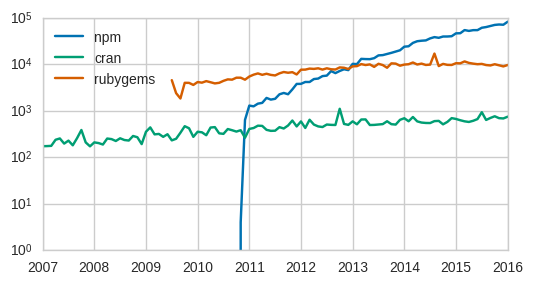

In [8]:
fig, ax = matplotlib.pyplot.subplots()

for ecos, pkg in df_pkg.items():
    df = (pkg
        .groupby(level=['package', 'version'])
        [['time']]
        .min()
        .set_index('time')
        .assign(**{ecos: 1})
        .resample('1M')
        .count()
        .rename(columns={'n': ecos})
    )
    df.plot(ax=ax, color=COLORS[ecos], logy=True)

if SHOW_TITLE:
    ax.set_title('Number of new releases by month')

ax.set_xlabel('')
#ax.set_ylabel('# releases (by month)')
ax.set_ylabel('')
ax.set_xlim(left=pandas.to_datetime('2007-01-01'), right=pandas.to_datetime('2016-01-01'))

fig.set_size_inches(FIG_SIZE)

savefig(fig, 'updates_evolution')

In [25]:
for ecos in ecosystems:
    n_pkg = len(df_pkg[ecos]
         .groupby(level='package')
         [['time']]
         .min()
         .pipe(lambda d: d[d['time'].dt.year == 2015])
    )
    n_upd = len(df_pkg[ecos][df_pkg[ecos]['time'].dt.year == 2015])
    
    print(ecos, 'new packages in 2015:', n_pkg)
    print('updates:', n_upd)

npm new packages in 2015: 113613
updates: 711317
Average: 6.260876836277538
cran new packages in 2015: 1660
updates: 8140
Average: 4.903614457831325
rubygems new packages in 2015: 18639
updates: 121394
Average: 6.5129030527388805


In [39]:
for ecos, pkg in df_pkg.items():
    n_pkg = len(pkg
        [pkg['time'].dt.year <= 2015]
        .groupby(level='package')
    )
    n_upd = len(pkg
        [pkg['time'].dt.year == 2015]
        .groupby(level='package')
    )
    
    print(ecos, ' - available packages in 2015-end:', n_pkg)
    print('Updated packages in 2015:', n_upd)
    print('Proportion:', n_upd / n_pkg)

npm  - available packages in 2015-end: 234866
Updated packages in 2015: 142649
Proportion: 0.6073633476109782
cran  - available packages in 2015-end: 8937
Updated packages in 2015: 4246
Proportion: 0.47510350229383463
rubygems  - available packages in 2015-end: 111800
Updated packages in 2015: 30455
Proportion: 0.27240608228980323


## Delay between new releases

npm
Results
   null distribution: chi squared
   test: logrank
   alpha: 0.99
   df: 1
   t 0: -1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |           4920.456 |      Reject Null    |        True       

cran
Results
   null distribution: chi squared
   test: logrank
   alpha: 0.99
   df: 1
   t 0: -1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |           1159.339 |      Reject Null    |        True       

rubygems
Results
   null distribution: chi squared
   test: logrank
   alpha: 0.99
   df: 1
   t 0: -1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |           6304.104 |      Reject Null    |        True       



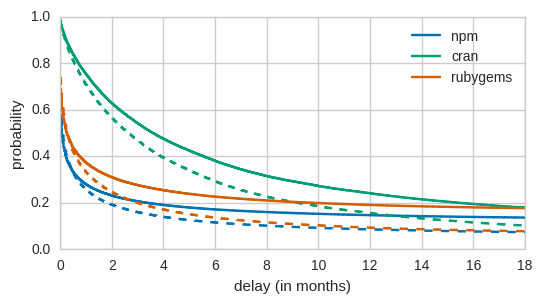

In [40]:
from lifelines.statistics import logrank_test

fig, ax = matplotlib.pyplot.subplots(1, 1)
kmp = lifelines.KaplanMeierFitter()

for ecos in ecosystems:
    pkg, deps = df_pkg[ecos], df_deps[ecos]
    
    df = (pkg
       .assign(observed=lambda d: ~d['next_time'].isnull())
       .assign(duration=lambda d: 
                   (d['next_time'].fillna(d['time'].max()).astype('datetime64[ns, UTC]')
                   - d['time'].astype('datetime64[ns, UTC]')).dt.days / 30)
       .reset_index()
       .merge(deps[['dependency']]
                  .drop_duplicates()
                  .assign(required=True)
              , how='left', left_on='package', right_on='dependency')
       .set_index(['package', 'version'])
       .fillna({'required': False})
    )

    kmp.fit(df['duration'], df['observed'], label=ecos)
    kmp.plot(ax=ax, color=COLORS[ecos], ci_show=False)
    
    _ = df.query('required == True')
    kmp.fit(_['duration'], _['observed'])
    kmp.plot(ax=ax, color=COLORS[ecos], style='--', legend=None, ci_show=False)
    
    results = logrank_test(df['duration'], _['duration'], df['observed'], _['observed'], alpha=.99)
    print(ecos)
    results.print_summary()
    print()
    
ax.set_xlabel('delay (in months)')
ax.set_ylabel('probability')
if SHOW_TITLE:
    ax.set_title('Probability that a package is not updated')
ax.set_xlim(right=18)
ax.set_ylim(0, 1)

fig.set_size_inches(FIG_SIZE)

savefig(fig, 'updates_survival')

# Constraints

In [5]:
data = []

for ecos in ecosystems:
    for date in DATE_RANGE:
        pkg, deps = snapshot(date, df_pkg[ecos], df_deps[ecos])
        
        data.append((ecos, date, 'packages', len(pkg)))
        data.append((ecos, date, 'dependencies', len(deps)))
        data.append((ecos, date, 'packages_with_deps', len(deps.groupby('package'))))
        
        _ = deps.query('constraint_defined == True')
        data.append((ecos, date, 'deps_constraint', len(_)))
        data.append((ecos, date, 'pkg_constraint', len(_.groupby('package'))))
        
        _ = deps.query('constraint_strict == True')
        data.append((ecos, date, 'deps_fixed', len(_)))
        data.append((ecos, date, 'pkg_fixed', len(_.groupby('package'))))
        
        _ = deps.query('constraint_lower == True')
        data.append((ecos, date, 'deps_lower', len(_)))
        data.append((ecos, date, 'pkg_lower', len(_.groupby('package'))))
        
        _ = deps.query('constraint_upper == True')
        data.append((ecos, date, 'deps_upper', len(_)))
        data.append((ecos, date, 'pkg_upper', len(_.groupby('package'))))
        
data = pandas.DataFrame(data, columns=['ecosystem', 'date', 'kind', 'value'])        

## Evolution of the use of constraints

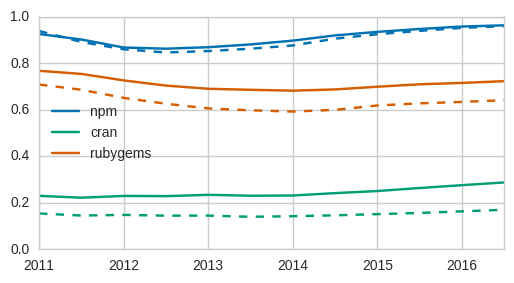

In [46]:
fig, ax = matplotlib.pyplot.subplots()

for ecos in ecosystems:
    df = (data
        .query('ecosystem == "{}"'.format(ecos))
        .pivot('date', 'kind', 'value')
        .assign(_deps=lambda d: d['deps_constraint'] / d['dependencies'])
        .assign(_pkg=lambda d: d['pkg_constraint'] / d['packages_with_deps'])
        [['_deps', '_pkg']]
        .rename(columns={'_pkg': ecos})
    )
    
    df[[ecos]].plot(ax=ax, style='-', color=COLORS[ecos])
    df[['_deps']].plot(ax=ax, legend=False, style='--', color=COLORS[ecos])

ax.legend(title='', loc='center left')

ax.set_ylim(0, 1)
ax.set_xlabel('')
ax.set_ylabel('')
fig.set_size_inches(FIG_SIZE)
if SHOW_TITLE:
    ax.set_title('Evolution of the proportion of constraints')
    
savefig(fig, 'constraints_evolution')

In [50]:
(data
        .query('ecosystem == "{}"'.format('rubygems'))
        .pivot('date', 'kind', 'value')
        .assign(_deps=lambda d: d['deps_constraint'] / d['dependencies'])
        .assign(_pkg=lambda d: d['pkg_constraint'] / d['packages_with_deps'])
        [['_deps', '_pkg']]
    )

kind,_deps,_pkg
date,,
2011-01-31,0.708707,0.767618
2011-07-31,0.686130,0.754238
2012-01-31,0.651198,0.726330
2012-07-31,0.625948,0.704046
2013-01-31,0.605917,0.690360
2013-07-31,0.597806,0.685924
2014-01-31,0.592484,0.682225
2014-07-31,0.599605,0.687539
2015-01-31,0.618389,0.699175


## Evolution of the use of types of constraints

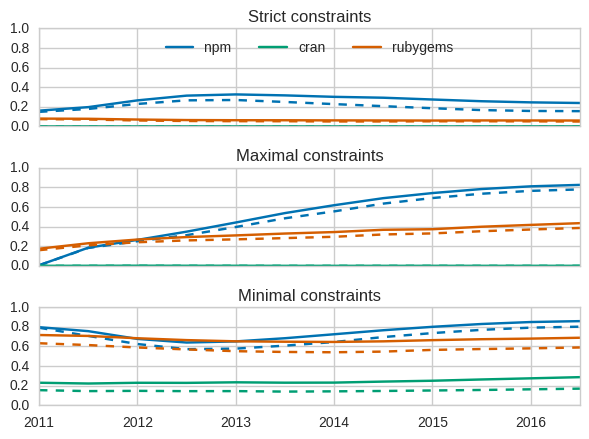

In [6]:
fig, axes = matplotlib.pyplot.subplots(nrows=3, sharex=True, sharey=True)

for ecos in ecosystems:
    df = (data
        .query('ecosystem == "{}"'.format(ecos))
        .pivot('date', 'kind', 'value')
        .assign(p_constraint=lambda d: d['deps_constraint'] / d['dependencies'])
        .assign(p_strict=lambda d: d['deps_fixed'] / d['dependencies'])
        .assign(p_lower=lambda d: d['deps_lower'] / d['dependencies'])
        .assign(p_upper=lambda d: d['deps_upper'] / d['dependencies']) 
        .assign(p_pkg_constraint=lambda d: d['pkg_constraint'] / d['packages_with_deps'])
        .assign(p_pkg_strict=lambda d: d['pkg_fixed'] / d['packages_with_deps'])
        .assign(p_pkg_lower=lambda d: d['pkg_lower'] / d['packages_with_deps'])
        .assign(p_pkg_upper=lambda d: d['pkg_upper'] / d['packages_with_deps'])           
        [['p_constraint', 'p_strict', 'p_upper', 'p_lower',
          'p_pkg_constraint', 'p_pkg_strict', 'p_pkg_upper', 'p_pkg_lower']]
    )
    df[['p_strict']].rename(columns={'p_strict': '_'}).plot(ax=axes[0], color=COLORS[ecos], style='--')
    df[['p_upper']].rename(columns={'p_upper': '_'}).plot(ax=axes[1], color=COLORS[ecos], style='--')
    df[['p_lower']].rename(columns={'p_lower': '_'}).plot(ax=axes[2], color=COLORS[ecos], style='--')
    
    df[['p_pkg_strict']].rename(columns={'p_pkg_strict': ecos}).plot(ax=axes[0], color=COLORS[ecos], style='-')
    df[['p_pkg_upper']].rename(columns={'p_pkg_upper': ecos}).plot(ax=axes[1], color=COLORS[ecos], style='-')
    df[['p_pkg_lower']].rename(columns={'p_pkg_lower': ecos}).plot(ax=axes[2], color=COLORS[ecos], style='-')

axes[0].set_title('Strict constraints')
axes[1].set_title('Maximal constraints')
axes[2].set_title('Minimal constraints')

axes[0].legend(title='', loc='upper center', ncol=3)
axes[1].legend().set_visible(False)
axes[2].legend().set_visible(False)

for i in range(3):
    axes[i].set_ylim(0, 1)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

fig.set_size_inches((FIG_SIZE[0], FIG_SIZE[1] * 1.5))
fig.tight_layout()
if SHOW_TITLE:
    fig.sup_title('Evolution of the proportion of strict constraints')
    
savefig(fig, 'constraints_strict_evolution')

## Conflicting strict constraints

In [20]:
data = []

for ecos in ecosystems:
    for date in DATE_RANGE:
        pkg, deps = snapshot(date, df_pkg[ecos], df_deps[ecos])
        
        data.append((ecos, date, 'packages', len(pkg)))
        
        # Packages that are required by at least x strict constraints
        f = lambda i: (deps
            .query('constraint_strict == True')
            .groupby('dependency')
            .filter(lambda g: len(g) >= i)
            .drop_duplicates(['dependency'])
        )
        #data.append((ecos, date, 'required_by_1', len(f(1))))
        data.append((ecos, date, 'required_by_2', len(f(2))))
        
        # Packages that are required by at least 2 distinct strict constraints
        _ = (deps
            .query('constraint_strict == True')
            .drop_duplicates(['dependency', 'constraint'])
            .groupby('dependency')
            .filter(lambda g: len(g) >= 2)
            .drop_duplicates(['dependency'])
            )
        data.append((ecos, date, 'required_by_2_distinct', len(_)))
        
data = pandas.DataFrame(data, columns=['ecosystem', 'date', 'kind', 'value'])        

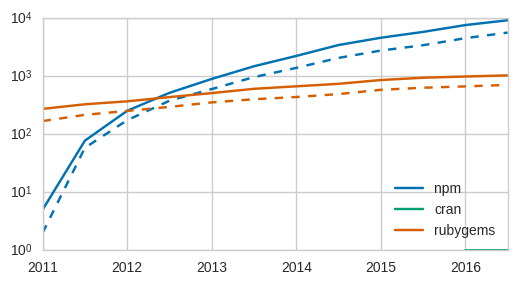

In [21]:
fig, ax = matplotlib.pyplot.subplots()

for ecos in ecosystems:
    df = (data
        .query('ecosystem == "{}"'.format(ecos))
        .pivot('date', 'kind', 'value')
        [['required_by_2', 'required_by_2_distinct']]
        .rename(columns={'required_by_2': ecos, 'required_by_2_distinct': '_'})
    )
    
    df[[ecos]].plot(ax=ax, style='-', color=COLORS[ecos])
    df[['_']].plot(ax=ax, style='--', legend=False, color=COLORS[ecos])

ax.legend(title='', loc='lower right')

#ax.set_ylim(1, 3)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yscale('log')
fig.set_size_inches(FIG_SIZE)
if SHOW_TITLE:
    ax.set_title('Evolution of the number of packages that are required by at least 2 (conflicting) strict constraints')
    
savefig(fig, 'constraints_conflict_evolution')

## Delay to change a constraint

npm True 180    0.355728
Name: npm, dtype: float64
npm False 180    0.238411
Name: npm, dtype: float64
rubygems True 180    0.645353
Name: rubygems, dtype: float64
rubygems False 180    0.22167
Name: rubygems, dtype: float64


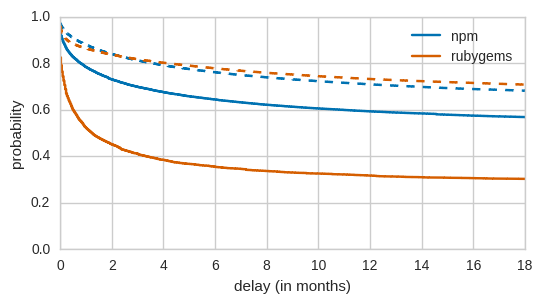

In [22]:
fig, ax = matplotlib.pyplot.subplots(1, 1)

for ecos, df in df_delay.items():
    if ecos == 'cran':
        continue
        
    for is_fixed in [True, False]:
        ndf = df.query('constraint_strict == ' + str(is_fixed))
        observed = ~ndf['next_time'].isnull()
        duration = (
            (ndf['next_time'].fillna(df['time'].max()).astype('datetime64[ns, UTC]')
             - ndf['time'].astype('datetime64[ns, UTC]')).dt.days / 30
        )
        kmp = lifelines.KaplanMeierFitter()
        kmp.fit(duration, observed, label=ecos)
        kmp.plot(style='-' if is_fixed else '--', 
                 ci_show=False,
                 legend=ecos if is_fixed else None,
                 ax=ax, 
                 color=COLORS[ecos])
        print(ecos, is_fixed, 1 - kmp.survival_function_.reset_index().query('timeline >= 6').head(1)[ecos])

ax.set_xlabel('delay (in months)')
ax.set_ylabel('probability')
if SHOW_TITLE:
    ax.set_title('Probability that a constraint is not updated')
ax.set_xlim(right=18)
ax.set_ylim(0, 1)

fig.set_size_inches(FIG_SIZE)

savefig(fig, 'constraints_survival')

## Delay to change a strict constraint since a new release

In [7]:
for ecos in ecosystems:
    pkg, delay = df_pkg[ecos], df_delay[ecos]
    if ecos == 'cran':
        continue
    stricts = delay.query('constraint_strict == True')
    n_strict = len(stricts)
    n_strict_adjusted = len(stricts.dropna(subset=['next_time']))
    n_strict_adjusted_targeted = len(stricts
        .dropna(subset=['next_time'])
        .rename(columns={'next_time': 'next_constraint_update'})
        # Next update for targeted package
        .merge(pkg[['next_time']], how='left', left_on=['dependency', 'constraint'], right_index=True)
        .rename(columns={'next_time': 'next_target_update'})
    )
    n_strict_adjusted_targeted_updated = len(stricts
        .dropna(subset=['next_time'])
        .rename(columns={'next_time': 'next_constraint_update'})
        # Next update for targeted package
        .merge(pkg[['next_time']], how='left', left_on=['dependency', 'constraint'], right_index=True)
        .rename(columns={'next_time': 'next_target_update'})
        # Remove target packages that are not updated
        .dropna(subset=['next_target_update'])
    )
    n_strict_adjusted_targeted_updated_after = len(stricts
        .dropna(subset=['next_time'])
        .rename(columns={'next_time': 'next_constraint_update'})
        # Next update for targeted package
        .merge(pkg[['next_time']], how='left', left_on=['dependency', 'constraint'], right_index=True)
        .rename(columns={'next_time': 'next_target_update'})
        # Remove target packages that are not updated
        .dropna(subset=['next_target_update'])
        .assign(delay=lambda d: d['next_constraint_update'] - d['next_target_update'])
        # Drop negative delay, since it means they changed the constraint to something not interesting for us
        .pipe(lambda d: d[d['delay'] > pandas.Timedelta('0D')])
    )
    print(ecos)
    print('stricts:', n_strict)
    print('adjusted:', n_strict_adjusted, n_strict_adjusted / n_strict)
    print('with existing target:', n_strict_adjusted_targeted, n_strict_adjusted_targeted / n_strict_adjusted)
    print('... updated target:', n_strict_adjusted_targeted_updated, n_strict_adjusted_targeted_updated / n_strict_adjusted_targeted)
    print('... after:', n_strict_adjusted_targeted_updated_after, n_strict_adjusted_targeted_updated_after / n_strict_adjusted_targeted_updated)
    print('which represents', n_strict_adjusted_targeted_updated_after / n_strict, ' of all strict constraints')

npm
stricts: 218537
adjusted: 84692 0.38754078256771163
with existing target: 84692 1.0
... updated target: 76522 0.9035328012090871
... after: 69823 0.9124565484435848
which represents 0.3195019607663691  of all strict constraints
rubygems
stricts: 36408
adjusted: 25296 0.6947923533289387
with existing target: 25296 1.0
... updated target: 24871 0.9831989247311828
... after: 21124 0.8493426078565397
which represents 0.580202153372885  of all strict constraints


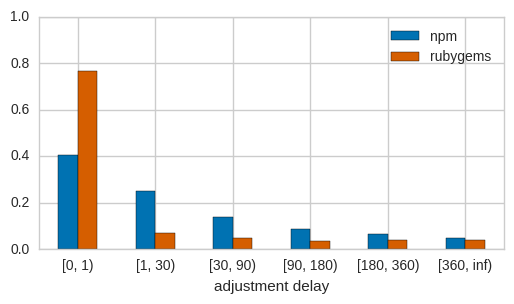

In [5]:
#bins = [0, 1, 15, 45, 90, 180, 365, pandas.np.inf]
bins = [0, 1, 30, 90, 180, 360, pandas.np.inf]
data = pandas.DataFrame()

for ecos in ecosystems:
    pkg, delay = df_pkg[ecos], df_delay[ecos]
    if ecos == 'cran':
        continue
    data[ecos] = (delay
          # Consider fixed constraints
          .query('constraint_strict == True')
          ## Constraints that are not updated are considered updated now
          #.fillna({'next_time': pkg.time.max()})
          .dropna(subset=['next_time'])
          .rename(columns={'next_time': 'next_constraint_update'})
          # Next update for targeted package
          .merge(pkg[['next_time']], how='left', left_on=['dependency', 'constraint'], right_index=True)
          .rename(columns={'next_time': 'next_target_update'})
          # Remove target packages that are not updated
          .dropna(subset=['next_target_update'])
          # Delay since missed update
          .assign(delay=lambda d: d['next_constraint_update'] - d['next_target_update'])
          # Drop negative delay, since it means they changed the constraint to something not interesting for us
          .pipe(lambda d: d[d['delay'] > pandas.Timedelta('0D')])
          # Make bins
          .assign(delay_bins=lambda d: pandas.cut(d['delay'].dt.days, bins, right=False))
          # Group by delay
          .groupby('delay_bins')
          ['version']
          .count()     
          .pipe(lambda d: d / d.sum())
          ## Count distinct packages by bin
          #['package'].nunique()
          # Relative to the number of releases with a fixed constraint
          #.div(len(delay.drop_duplicates(['package', 'version'])))
    )
    
ax = data.plot(kind='bar', rot=0, color=[c for e, c in COLORS.items() if e != 'cran'])

if SHOW_TITLE:
    ax.set_title('Proportion of moment when a strict constraint targets an outdated version, by delay')

ax.legend(loc='upper right')
ax.set_xlabel('adjustment delay')
ax.set_ylabel('')
ax.set_ylim(0, 1)

ax.figure.set_size_inches(FIG_SIZE)

savefig(ax.figure, 'constraints_delay')

In [56]:
data

,npm,rubygems
delay_bins,,
"[0, 1)",0.407502,0.766758
"[1, 30)",0.251608,0.069684
"[30, 90)",0.141085,0.048002
"[90, 180)",0.085745,0.035315
"[180, 360)",0.066740,0.039386
"[360, inf)",0.047320,0.040854
